In [31]:
import datetime
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import pandas as pd
import json
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np

init_notebook_mode(connected=True)

In [12]:
input_file = "Test_Data.log"
timestamp_format = "%Y-%m-%dT%H:%M:%S"
timestamp_correction_hours = 10

In [13]:
data = pd.read_csv('Test_Data.log')
data.head()

{'micros': 203531  \
{'offset': 80   'x': 68   'y': -1226       'z': -16203   
{'offset': 90   'x': -7   'y': -1210       'z': -16041   
{'offset': 100  'x': -36  'y': -1224       'z': -16040   
{'offset': 110  'x': -27  'y': -1219       'z': -16016   
{'offset': 120  'x': -24  'y': -1201       'z': -16058   

                                       'time': '2019-04-24T04:48:36'}  
{'offset': 80   'x': 68   'y': -1226   'time': '2019-04-24T04:48:36'}  
{'offset': 90   'x': -7   'y': -1210   'time': '2019-04-24T04:48:36'}  
{'offset': 100  'x': -36  'y': -1224   'time': '2019-04-24T04:48:36'}  
{'offset': 110  'x': -27  'y': -1219   'time': '2019-04-24T04:48:36'}  
{'offset': 120  'x': -24  'y': -1201   'time': '2019-04-24T04:48:36'}

In [14]:
with open(input_file) as f:
    lines = f.readlines()

In [15]:
with open(input_file) as f:
    lines = f.readlines()
entries = []
micros = 0
for l in lines:
    l = l.strip('\n')
    l = l.replace('\'', '\"')
    # Correct timestamps
    e = json.loads(l)
    if 'micros' in e.keys():
        micros = e["micros"]
    e['datetime'] = datetime.datetime.strptime(e['time'], timestamp_format)
    + datetime.timedelta(hours=timestamp_correction_hours)
    e['datetime'] += datetime.timedelta(microseconds=micros)
    if 'offset' in e.keys():
        e['datetime'] += datetime.timedelta(microseconds=(e['offset']*1000))

    entries.append(e)
    
df = pd.DataFrame(entries)
df = df.sort_values(by='datetime')
df = df.drop(df[df['datetime'] < '2019-01-01'].index)

In [16]:
df.describe()

micros        offset  temperature  v_battery             x  \
count      15.000000  13893.000000    11.000000    3.00000  13893.000000   
mean   203568.133333   4958.714892    11.901989   -2.25400    134.349529   
std        28.192873   2902.741312    45.472758   11.91651    606.946223   
min    203527.000000      0.000000  -125.203125  -16.01400 -16127.000000   
25%    203552.500000   2417.000000    25.500000   -5.69400    -17.000000   
50%    203563.000000   4945.000000    25.625000    4.62600    122.000000   
75%    203577.500000   7476.000000    25.687500    4.62600    245.000000   
max    203633.000000  15647.000000    25.750000    4.62600  32251.000000   

                  y             z  
count  13893.000000  13893.000000  
mean   -1039.308501 -15409.278702  
std      610.579941   4254.886718  
min   -25663.000000 -32413.000000  
25%    -1181.000000 -16271.000000  
50%    -1045.000000 -16027.000000  
75%     -916.000000 -14607.000000  
max    23804.000000  26049.000000

In [17]:
accel = df.loc[df['x'].notnull()].reset_index()[['datetime', 'x', 'y', 'z']]

In [18]:
x = go.Scatter(x=accel['datetime'], y=accel.x, name="x")
y = go.Scatter(x=accel.datetime, y=accel.y, name="y")
z = go.Scatter(x=accel.datetime, y=accel.z, name="z")

data = [x,y,z]

layout = go.Layout()
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [36]:
strain = df.loc[df['strain'].notnull()].reset_index().loc[:, ['datetime', 'strain']]

KeyError: 'strain'

In [22]:
initial_strain = strain.iloc[0]['strain']
strain.loc[:, 'strain_diff'] = initial_strain + strain['strain']

NameError: name 'strain' is not defined

In [37]:
raw_strain = go.Scatter(x=strain['datetime'], y=strain['strain'], name="Strain")
diff_strain = go.Scatter(x=strain['datetime'], y=strain['strain_diff'], name="Strain (diff)")
data = [raw_strain, diff_strain]
layout = go.Layout(xaxis=dict(title="Date"), yaxis=dict(title="Strain"))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

NameError: name 'strain' is not defined

In [25]:
temperature = df[df["temperature"].notnull()][df["temperature"] != 0][["temperature", "datetime"]].sort_values(by='datetime')

C:\Users\lizzi\Anaconda3\envs\thesis2\lib\site-packages\ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [26]:
t = go.Scatter(x=temperature['datetime'], y=temperature['temperature'], name="Case Temperature")
l = go.Layout(xaxis=dict(title="Date"), yaxis=dict(title="Temperature (\degC)"))
f = go.Figure(data=[t], layout=l)
iplot(f)

In [27]:
battery = df.loc[df['v_battery'].notnull(), ['datetime', 'v_battery']]

In [28]:
p = go.Scatter(x=battery['datetime'], y=battery['v_battery'], name="BatteryVoltage")
layout = go.Layout(yaxis=dict(title="Voltage (V)", ticksuffix="V", range=(0,6)))
fig = go.Figure(data=[p], layout=layout)
iplot(fig)

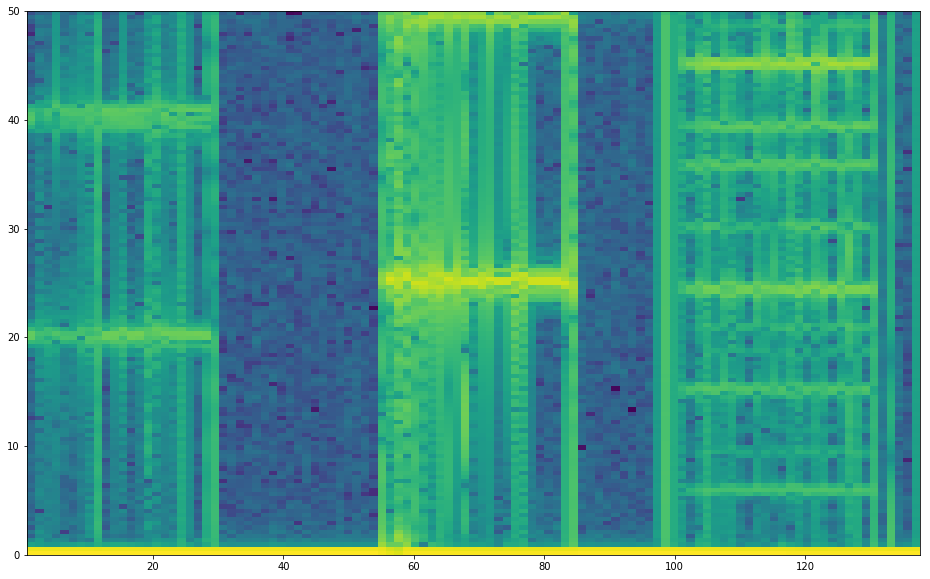

In [29]:
fig, ax = plt.subplots(figsize=(16,10))
ax.specgram(accel['z'], Fs=100, NFFT=256, noverlap=128)
plt.show()

In [33]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [34]:
# Filter requirements.
order = 6
fs = 100    # sample rate, Hz
cutoff = 25   # desired cutoff frequency of the filter, Hz

B, A = signal.butter(order, (2*cutoff)/fs, output='ba', analog=False)
smoothed = signal.filtfilt(B, A, accel['z'])

smooth = go.Scatter(y=smoothed, name="Smooth")
raw = go.Scatter(y=accel['z'], name="Raw")
data = [raw, smooth]
l = go.Layout()
fig = go.Figure(data=data, layout=l)
iplot(fig)

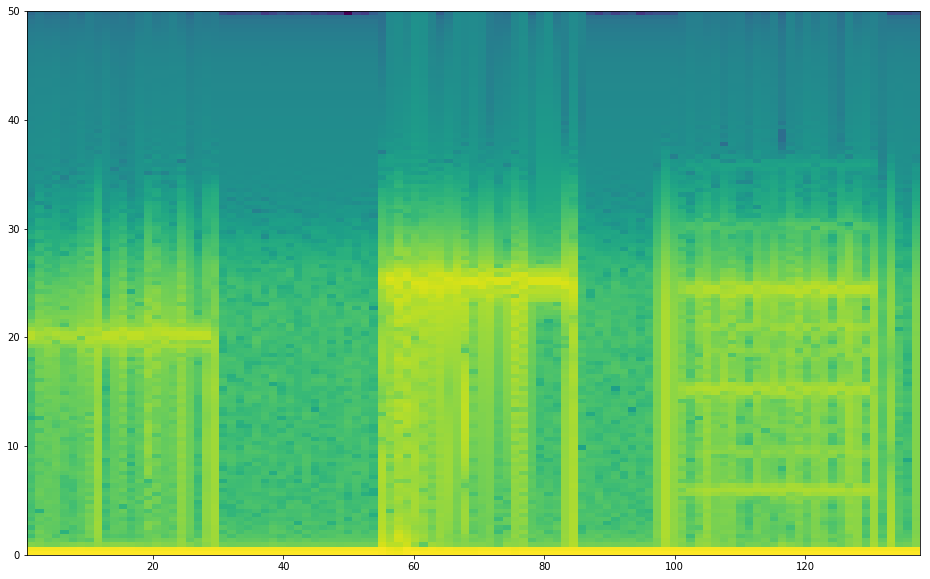

In [35]:
fig, ax = plt.subplots(figsize=(16,10))
ax.specgram(smoothed, Fs=100, NFFT=256, noverlap=128)
plt.show()